In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.applications import MobileNetV2
from keras import layers, Model

# No mezclar churras con merinas

## 1 El problema
Este problema requiere crear un modelo de clasificación binaria de imágenes, entrenarlo con fotos de ovejas de las razas churra y merina para después poder clasificar nuevas imágenes entrantes.

Los datos se encuentran en las carpetas train y test, cada una de ellas dividida otras dos carpetas separando las churras y las merinas.

In [2]:
root_path = "./data/"
train_path = root_path + "train"
test_path = root_path + "test"

## 2 Los datos

### 2.1 Carga

Definimos una funcion que:

- itera en los directorios
- lee las imágenes
- transforma los tres canales RGB a array
- obtiene la etiqueta de la imagen del nombre de su directorio

In [3]:
def read_data(directorio, reshape_dim=(32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir(os.path.join(directorio, folder)):
            for file in os.listdir(os.path.join(directorio, folder)):
                image_path = os.path.join(directorio, folder, file)
                image = cv2.imread(image_path)
                if image is not None:  # Verificar si la imagen se leyó correctamente
                    image = cv2.resize(image, reshape_dim)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convertimos de BGR a RGB

                    X.append(image)
                    y.append(folder)
                else:
                    print(f"Advertencia: No se pudo leer la imagen correctamente: {image_path}")
    return np.array(X), np.array(y)


In [6]:
X_test, y_test = read_data(test_path, reshape_dim=(128,128))
X_train, y_train = read_data(train_path, reshape_dim=(128,128))

Con ello obtenemos arrays X tridimensionales

In [7]:
X_train.shape, X_test.shape

((291, 128, 128, 3), (80, 128, 128, 3))

### 2.2 Visualización

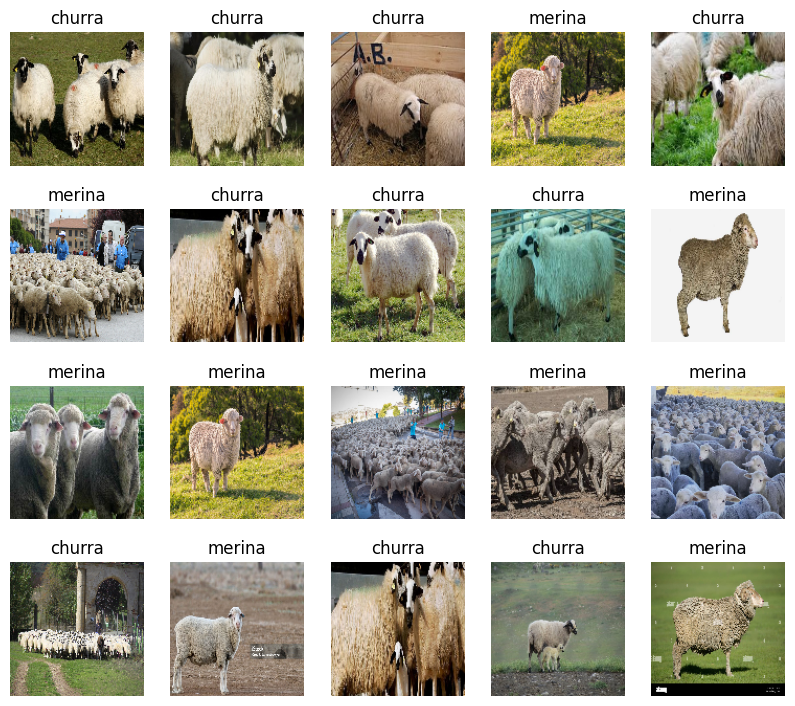

In [8]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])
            
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

### 2.3 MiniEDA

Vemos que se trata de unos datos balanceados

In [10]:
pd.Series(y_train).value_counts(True)

churra    0.501718
merina    0.498282
Name: proportion, dtype: float64

Escalamos los datos para tener los datos en un rango de 0 a 1, a pesar de que los datos estén ya esten en la misma escala, esto aprovechará mejor las funciones de activación y evita problemas de saturación.

In [11]:
X_train = X_train/255
X_test = X_test/255

Como los datos están ordenados, es necesario darle cierta aleatoriedad

In [12]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

Las redes convolucionales requieren etiquetas numéricas para entrenar, por lo tanto realizaremos una transformación.´

Prepararemos dos diccionarios para mapear las etiquetas

In [ ]:
# este para entrenar
mapa = {"churra":0,
        "merina":1}

# y este para luego ver los resultados
inverse_mapping = {0:"churra",
                   1:"merina"}

In [ ]:
y_train_num = np.array(pd.Series(y_train).map(mapa))
y_test_num = np.array(pd.Series(y_test).map(mapa))

## 3 El modelo

Para el modelo vamos a usar Transfer Learning.  
Usaremos la cabeza de MobileNetV2 y una única capa densa con tantas unidades como la resolución de las imágenes aplanada.

In [19]:
output = 128*128
output

16384

In [20]:
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False

def prepare_model(base_model=base_model):
    x = layers.Flatten()(base_model.output)

    x = layers.Dense(output, activation="relu")(x)
    x = layers.Dropout(rate=.50)(x)

    x = layers.Dense(2, activation="softmax")(x)

    model = Model(base_model.input,x)

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
    
    return model

model = prepare_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 337,851,458 (1.26 GB)

 Trainable params: 335,593,474 (1.25 GB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [22]:
model = prepare_model()
history = model.fit(X_train, y_train_num,
                    batch_size = 32,
                    validation_split = .2,
                    epochs = 100,
                    callbacks = [early_stopping])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - acc: 0.5708 - loss: 62.1082 - val_acc: 0.5254 - val_loss: 38.7262
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - acc: 0.6675 - loss: 23.4420 - val_acc: 0.7119 - val_loss: 23.9982
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - acc: 0.8160 - loss: 8.3030 - val_acc: 0.8475 - val_loss: 6.7458
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - acc: 0.9315 - loss: 1.5287 - val_acc: 0.8814 - val_loss: 4.3722
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - acc: 0.9775 - loss: 0.4229 - val_acc: 0.8644 - val_loss: 5.5305
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - acc: 0.9715 - loss: 0.3866 - val_acc: 0.8644 - val_loss: 3.7108
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - acc: 0.9985 - loss: 0.0088 - val_acc: 0.8814 - val_loss: 5.6095
Epoch 8/100
3/8 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - acc: 0.9809 - loss: 0.1344

KeyboardInterrupt: 